### Imports

In [1]:
import numpy as np
import pandas as pd

from scipy.integrate import odeint
from scipy.optimize import differential_evolution

import sdeparams

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='Set2')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

import warnings
warnings.filterwarnings('ignore')

### Functions

$$\frac{\mathrm{d}\mathbf{x}}{\mathrm{d} t} = \mathbf{A}(\mathbf{x}) + \frac{1}{\sqrt{N}}\boldsymbol{\eta}(t)$$

$$\frac{\mathrm{d}\boldsymbol{\Xi}}{\mathrm{d} t} = \mathbf{J}(\mathbf{x}_{\rm det}(t))\, \mathbf{\Xi} + \mathbf{\Xi}\, \mathbf{J}(\mathbf{x}_{\rm det}(t))^\top + \mathbf{B}(\mathbf{x}_{\rm det}(t))$$

$$\mathbf{\Xi}(t) = N \left\langle (\mathbf{x}(t) - \mathbf{x}_{\rm det}(t))\, (\mathbf{x}(t) - \mathbf{x}_{\rm det}(t))^\top \right\rangle$$

#### Two toy models

1. A logistic birth-death process in 1D
2. An SIR model in 2D

The function `'path'` returns one realisation of the process. This is only for illustration purposes, since we obtain artificial data from it.

In [2]:
def A_1(x, *params):
    b, d, N = params
    return b*x*(1. - x) - d*x

def B_1(x, *params):
    b, d, N = params
    return max(b*x*(1. - x) + d*x, 0.)

def Jac_1(x, *params):
    b, d, N = params
    
    return b*(1. - 2*x) - d

def A_2(x, *params):
    s0, beta, gamma, N = params
    i, s = x
    return np.array([beta*s*i - gamma*i, -beta*s*i])

def B_2(x, *params):
    s0, beta, gamma, N = params
    i, s = x
    return np.maximum(np.array([[beta*s*i + gamma*i, -beta*s*i],[-beta*s*i, beta*s*i]]), np.zeros((2,2)))

def Jac_2(x, *params):
    s0, beta, gamma, N = params
    i, s = x
    J = np.array([[beta*s-gamma, beta*i],[-beta*s, -beta*i]])
    
    return J


def path(x, t, *params):
    dt = t[1]-t[0]
    
    N = params[-1]
    
    x_t = []
    
    if isinstance(x, float) or isinstance(x, int):
        for  time in t:
            x_t.append(x)
            y = A(x, *params)*dt + np.sqrt(dt*B(x, *params)/N)*np.random.normal()
            x += y
    else:
        n_dim = len(x)
        x_0 = x.copy()
        for time in t:
            x_t.append(x_0.copy())
            y = A(x_0, *params)*dt + np.sqrt(dt/N)*np.random.multivariate_normal(np.zeros(n_dim), B(x_0, *params))
            x_0 += y
            
    return np.array(x_t)

### Parameters

#### Number of dimensions and population size to use

In [3]:
n_dims = 2

N = 250

#### Birth-death

In [4]:
b = 3.068
d = 1.93
x0_1 = 0.5

#### SIR

In [5]:
beta = 2.97
gamma = 1.03
infected_start = 10
x0_2 = np.array([1.*infected_start/N,1.-1.*infected_start/N])

In [6]:
x0_2[0]

0.04

### The 'real' process

In [7]:
A = A_1 if n_dims == 1 else A_2
B = B_1 if n_dims == 1 else B_2
Jac = Jac_1 if n_dims == 1 else Jac_2

params = (b, d, N) if n_dims == 1 else (x0_2[1], beta, gamma, N)
x0 = x0_1 if n_dims == 1 else x0_2

dt = 0.001

t_full = np.arange(0., 10., dt)
x_real = path(x0, t_full, *params)

### Randomly sampled 'data'

In [28]:
measurements = np.sort(np.random.choice(range(len(t_full)), 100, replace=False))
artificial_timepoints = t_full[measurements]
artificial_data = x_real[measurements]

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

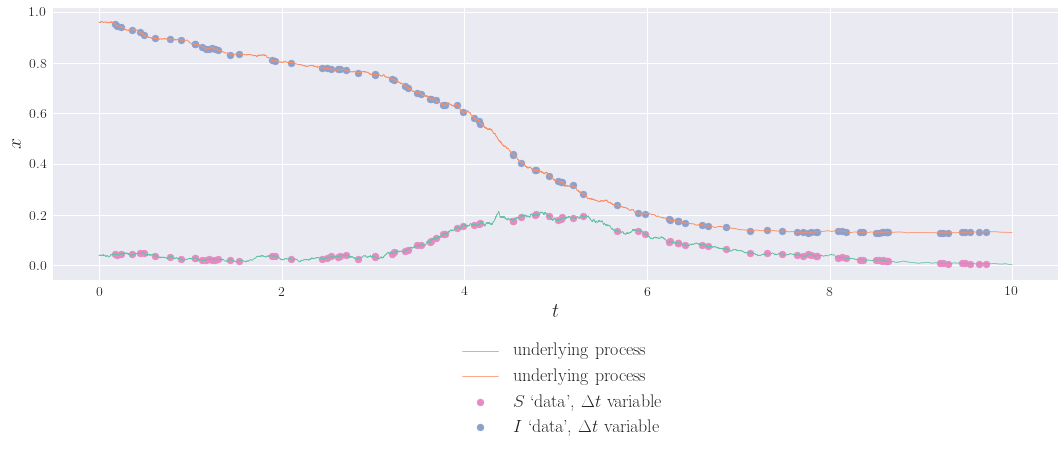

In [29]:
fig, ax = plt.subplots(1, figsize=(18,5))
ax.plot(t_full, x_real, linewidth=0.75, label=r"underlying process")
if n_dims == 1:
    ax.scatter(artificial_timepoints, artificial_data, color=colours[1], label=r"`data', $\Delta t$ variable")
else:
    ax.scatter(artificial_timepoints, artificial_data[:, 0], color=colours[3], label=r"$S$ `data', $\Delta t$ variable")
    ax.scatter(artificial_timepoints, artificial_data[:, 1], color=colours[2], label=r"$I$ `data', $\Delta t$ variable")
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$x$', fontsize=20)
ax.legend(fontsize=18, loc=(0.4,-0.6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### Zimmer's method

Given a set of parameter values:
- `'likelihood_next'` returns the PDF of the approximation evaluated at the real data point at time $t_{i+1}$
- `'costfn'` returns the total cost function
- `'draw_next'` returns a reconstructed data point at time $t_{i+1}$ given the data at time $t_i$
- `'reconstruct'` returns the array of reconstructed data points

Both `'likelihood_next'` and `'draw_next'` are implicitly called; respectively, by `'costfn'` and `'reconstruct'`.

**Note:** The choice of algorithm for the estimation itself is arbitrary

In [30]:
observations = (artificial_data[:,0], artificial_timepoints)

zimmer = sdeparams.Zimmer(A, B, Jac, observations, n_dims, n_obs=1)

In [35]:
bounds = [(0.9, 1.), (2., 5.), (0.5, 2.), (100, 500)]

estimation = differential_evolution(zimmer.costfn, bounds)

In [36]:
params_estim = tuple(estimation.x)

x_estim = zimmer.reconstruct(params_estim)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

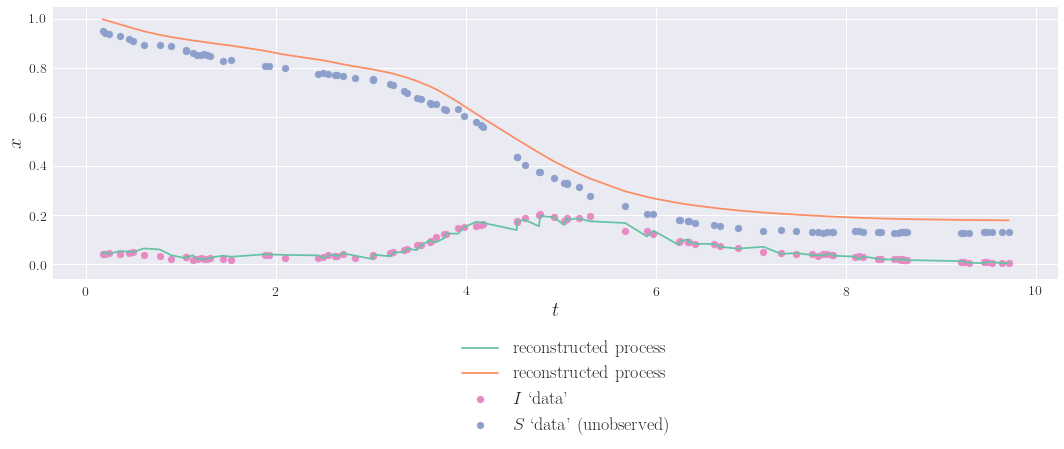

In [37]:
fig, ax = plt.subplots(1, figsize=(18,5))
ax.plot(artificial_timepoints, x_estim, label=r"reconstructed process")
if n_dims == 1:
    ax.scatter(artificial_timepoints, artificial_data, label=r"`data'", color=colours[1])
else:
    ax.scatter(artificial_timepoints, artificial_data[:, 0], color=colours[3], label=r"$I$ `data'")
    ax.scatter(artificial_timepoints, artificial_data[:, 1], color=colours[2], label=r"$S$ `data' (unobserved)")
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$x$', fontsize=20)
ax.legend(fontsize=18, loc=(0.4,-0.6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [38]:
init_cond = np.array([x0, 0.]) if n_dims == 1 else np.concatenate((x0, np.zeros(n_dims**2)))
x_real_det = odeint(LNA, init_cond, t_full, args=params)[:, :n_dims]
x_estim_det = odeint(LNA, init_cond, t_full, args=params_estim)[:, :n_dims]

NameError: name 'LNA' is not defined

In [ ]:
fig, ax = plt.subplots(1, figsize=(18,5))
ax.plot(t_full, x_real_det, linewidth=0.75, label=r"deterministic underlying process")
ax.plot(t_full, x_estim_det, linewidth=0.75, label=r"deterministic estimated process")
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$x$', fontsize=20)
ax.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [39]:
if n_dims == 1:
    params_table = {'process': ['real', 'estimated'], r'$b$': [b, params_estim[0]], r'$d$': [d, params_estim[1]], r'$N$': [N, params_estim[2]]}
else:
    params_table = {'process': ['real', 'estimated'], r'$\beta$': [beta, params_estim[1]], r'$\gamma$': [gamma, params_estim[2]], r'$N$': [N, params_estim[3]]}
params_table = pd.DataFrame(params_table)
params_table.set_index(['process'])

,$N$,$\beta$,$\gamma$
process,,,
real,250.000000,2.970000,1.030000
estimated,301.413604,2.550912,1.248512
